## 1. Theory: OLS with Newey–West (HAC) standard errors

In the paper, the spillover index (or its log-return) is regressed on a set of exogenous variables (fuel prices, loads, RES shares, …) using OLS and Newey–West robust standard errors to correct for heteroskedasticity and autocorrelation:

$$
S_t = \beta_0 + \beta_1 x_{1,t} + \dots + \beta_K x_{K,t} + \varepsilon_t,
$$

where

* ($S_t$) is the endogenous variable (e.g. total spillover, or “to others”, “from others”, etc.),
* ($x_{k,t}$) are exogenous regressors (here: CO₂/EUA, coal, TTF, …),
* ($\varepsilon_t$) is an error term that may be serially correlated and heteroskedastic.

OLS still gives unbiased/consistent point estimates under standard conditions, but the usual covariance estimator ($ \hat{\sigma}^2(X'X)^{-1}$) is wrong when errors are autocorrelated or heteroskedastic. Newey–West (HAC) replaces it with

$$
\widehat{\mathrm{Var}}*{\text{NW}}(\hat\beta)
= (X'X)^{-1} \left( \sum*{|\ell|\le L} w_\ell \Gamma_\ell \right) (X'X)^{-1},
$$

where

* ($\Gamma_\ell = \frac{1}{T} \sum_{t=\ell+1}^T u_t u_{t-\ell}' X_t' X_{t-\ell}$) are lag-($\ell$) autocovariances of residuals,
* ($w_\ell$) are Bartlett weights,
* ($L$) is the chosen truncation lag (“maxlags” in `statsmodels`).

In practice we:

1. Estimate OLS: ($\hat\beta = (X'X)^{-1}X'Y$).
2. Compute Newey–West robust covariance with chosen lag ($L$).
3. Use this covariance for t-stats, p-values and confidence intervals.

The code below implements exactly that via `statsmodels` (`cov_type="HAC"` and `cov_kwds={"maxlags": L}`), and runs *one regression per endogenous series*.





In [25]:
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

OUT_DIR = Path("../data/endogenous/prices/differenced")
endog_path = OUT_DIR / "endogenous_tsi_diff.parquet"
endog_levels_path = "../data/endogenous/prices/levels/endogenous_tsi_levels.parquet"
exog_path  = Path("../data/exogenous/all_exog_ready.parquet")

RESULTS_DIR = Path("../data/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Endog file:", endog_path)
print("Exog file :", exog_path)
print("Results ->", RESULTS_DIR)


Endog file: ..\data\endogenous\prices\differenced\endogenous_tsi_diff.parquet
Exog file : ..\data\exogenous\all_exog_ready.parquet
Results -> ..\data\results


In [26]:
# Load endogenous (endog)

# endog_raw = pd.read_parquet(endog_path) # differenced
endog_raw = pd.read_parquet(endog_levels_path)
display(endog_raw.head())

endog_raw["date"] = pd.to_datetime(endog_raw["date"])
endog = endog_raw.set_index("date").sort_index()

print("Endog shape:", endog_raw.shape)
print("Endog columns:", list(endog_raw.columns))

,date,tsi_mhar_recov_neg,tsi_mhar_recov_pos,tsi_mhar_recov,tsi_mhar_revar
0,2022-05-20,64.256845,67.315082,69.080499,40.959513
1,2022-05-21,64.822003,67.668933,69.399343,41.423628
2,2022-05-22,64.850782,67.722418,69.417585,41.513653
3,2022-05-23,64.868555,67.723980,69.427511,41.478449
4,2022-05-24,64.858373,67.697756,69.406709,41.445033


Endog shape: (1077, 5)
Endog columns: ['date', 'tsi_mhar_recov_neg', 'tsi_mhar_recov_pos', 'tsi_mhar_recov', 'tsi_mhar_revar']


In [27]:
# Load exogenous (exog) 

exog_raw = pd.read_parquet(exog_path)
display(exog_raw.head())

exog_raw["date"] = pd.to_datetime(exog_raw["date"])
exog = exog_raw.set_index("date").sort_index()

print("Exog shape:", exog_raw.shape)
print("Exog columns:", list(exog_raw.columns))

,date,TTF,co2,coal,load_energy_mwh_es,load_energy_mwh_fr,load_energy_mwh_pt,flow_net_mw_ES_FR,flow_net_mw_ES_PT,cac_eur_pts,ibex_eur_pts,psi_eur_pts,iberian_exception
0,2021-05-21,24.790001,51.29,69.997537,659567.0,1132950.0,132047.0,-3013.416667,651.616667,6386.410156,9204.000000,5271.569824,0
1,2021-05-22,24.790001,51.29,69.997537,588680.0,1034900.0,119301.0,-2942.129167,1609.212500,6386.410156,9204.000000,5271.569824,0
2,2021-05-23,24.790001,51.29,69.997537,541747.0,996300.0,110127.0,-2921.383333,1017.291667,6386.410156,9204.000000,5271.569824,0
3,2021-05-24,24.760000,52.68,69.954973,631285.0,1003400.0,129947.0,-3279.625000,1429.829167,6408.490234,9205.500000,5221.720215,0
4,2021-05-25,26.190001,51.24,69.959184,653439.0,1178900.0,134131.0,-2847.470833,400.925000,6390.270020,9208.700195,5221.720215,0


Exog shape: (1441, 13)
Exog columns: ['date', 'TTF', 'co2', 'coal', 'load_energy_mwh_es', 'load_energy_mwh_fr', 'load_energy_mwh_pt', 'flow_net_mw_ES_FR', 'flow_net_mw_ES_PT', 'cac_eur_pts', 'ibex_eur_pts', 'psi_eur_pts', 'iberian_exception']


In [28]:
# Choose which exogenous variables to use:
# - exog_cols = None uses ALL columns in the exog parquet
# - or provide a list, e.g. ["d_eua", "d_coal", "d_ttf"]

exog_cols = None  # <-- change here if you want a subset

if exog_cols is None:
    exog_names = list(exog.columns)
else:
    missing = [c for c in exog_cols if c not in exog.columns]
    if missing:
        raise ValueError(f"Missing exogenous columns: {missing}")
    exog_names = exog_cols

endog_names = list(endog.columns)

print("Using", len(endog_names), "endog series:", endog_names)
print("Using", len(exog_names), "exog vars  :", exog_names)

Using 4 endog series: ['tsi_mhar_recov_neg', 'tsi_mhar_recov_pos', 'tsi_mhar_recov', 'tsi_mhar_revar']
Using 12 exog vars  : ['TTF', 'co2', 'coal', 'load_energy_mwh_es', 'load_energy_mwh_fr', 'load_energy_mwh_pt', 'flow_net_mw_ES_FR', 'flow_net_mw_ES_PT', 'cac_eur_pts', 'ibex_eur_pts', 'psi_eur_pts', 'iberian_exception']


In [29]:
print("endog index type:", type(endog.index), "name:", endog.index.name)
print("exog  index type:", type(exog.index),  "name:", exog.index.name)
print("endog unique dates:", endog.index.is_unique)
print("exog  unique dates:", exog.index.is_unique)


endog index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> name: date
exog  index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> name: date
endog unique dates: True
exog  unique dates: True


In [30]:
# Align endog + exog on the same dates, drop rows with any NA

data = endog.join(exog[exog_names], how="inner")
print("After join:", data.shape)

data = data[endog_names + exog_names].dropna()
print("After dropna:", data.shape)
display(data.head())


After join: (1077, 16)
After dropna: (1077, 16)


,tsi_mhar_recov_neg,tsi_mhar_recov_pos,tsi_mhar_recov,tsi_mhar_revar,TTF,co2,coal,load_energy_mwh_es,load_energy_mwh_fr,load_energy_mwh_pt,flow_net_mw_ES_FR,flow_net_mw_ES_PT,cac_eur_pts,ibex_eur_pts,psi_eur_pts,iberian_exception
date,,,,,,,,,,,,,,,,
2022-05-20,64.256845,67.315082,69.080499,40.959513,87.90,80.02,317.234848,674298.0,1100450.0,138954.0,685.891667,1243.645833,6285.240234,8484.500000,5921.160156,0
2022-05-21,64.822003,67.668933,69.399343,41.423628,87.90,80.02,317.234848,578708.0,922600.0,114970.0,-1267.886957,1304.791304,6285.240234,8484.500000,5921.160156,0
2022-05-22,64.850782,67.722418,69.417585,41.513653,87.90,80.02,317.234848,555206.0,925600.0,114745.0,-1280.312500,1758.000000,6285.240234,8484.500000,5921.160156,0
2022-05-23,64.868555,67.723980,69.427511,41.478449,83.29,78.18,310.365797,2447339.0,1078700.0,133289.0,-184.662500,539.587500,6358.740234,8625.799805,6079.509766,0
2022-05-24,64.858373,67.697756,69.406709,41.445033,84.51,80.96,308.365940,2595676.0,1094650.0,136178.0,49.637500,236.762500,6253.140137,8631.200195,6130.899902,0


In [31]:
# quick sanity checks

print("Date range:", data.index.min(), "->", data.index.max())
print("\nMissing values per column (should be 0 now):")
display(data.isna().sum().sort_values(ascending=False).head(15))


Date range: 2022-05-20 00:00:00 -> 2025-04-30 00:00:00

Missing values per column (should be 0 now):


tsi_mhar_recov_neg    0
tsi_mhar_recov_pos    0
tsi_mhar_recov        0
tsi_mhar_revar        0
TTF                   0
co2                   0
coal                  0
load_energy_mwh_es    0
load_energy_mwh_fr    0
load_energy_mwh_pt    0
flow_net_mw_ES_FR     0
flow_net_mw_ES_PT     0
cac_eur_pts           0
ibex_eur_pts          0
psi_eur_pts           0
dtype: int64

In [32]:
# Run OLS + Newey–West (HAC) for each endogenous series
# This prints the default statsmodels summary output.

nw_lags = 10  # <-- maxlags for HAC

results = {}
X = sm.add_constant(data[exog_names])

for y_name in endog_names:
    y = data[y_name]
    model = sm.OLS(y, X)
    res = model.fit(cov_type="HAC", cov_kwds={"maxlags": nw_lags})
    results[y_name] = res

    print("\n" + "#" * 110)
    print(f"OLS + Newey–West (HAC) — ENDOG = {y_name}  |  maxlags={nw_lags}")
    print("#" * 110)
    print(res.summary())



##############################################################################################################
OLS + Newey–West (HAC) — ENDOG = tsi_mhar_recov_neg  |  maxlags=10
##############################################################################################################
                            OLS Regression Results                            
Dep. Variable:     tsi_mhar_recov_neg   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     89.01
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          2.95e-151
Time:                        12:53:35   Log-Likelihood:                -2185.6
No. Observations:                1077   AIC:                             4397.
Df Residuals:                    1064   BIC:                             4462.
Df Model:                          12                                         

In [33]:
# Build a tidy coefficient table

coef_rows = []

for y_name, res in results.items():
    ci = res.conf_int()
    for var in ["const"] + exog_names:
        coef_rows.append({
            "endog": y_name,
            "variable": var,
            "coef": res.params.get(var, np.nan),
            "std_err": res.bse.get(var, np.nan),
            "t": res.tvalues.get(var, np.nan),
            "pval": res.pvalues.get(var, np.nan),
            "ci_low":  ci.loc[var, 0] if var in ci.index else np.nan,
            "ci_high": ci.loc[var, 1] if var in ci.index else np.nan,
        })

coef_df = pd.DataFrame(coef_rows)
display(coef_df.head(20))
print("coef_df shape:", coef_df.shape)


,endog,variable,coef,std_err,t,pval,ci_low,ci_high
0,tsi_mhar_recov_neg,const,3.048718e+01,4.956218e+00,6.151299,7.685065e-10,2.077317e+01,4.020119e+01
1,tsi_mhar_recov_neg,TTF,-3.134060e-02,8.691844e-03,-3.605748,3.112555e-04,-4.837630e-02,-1.430490e-02
2,tsi_mhar_recov_neg,co2,-1.642312e-01,1.741812e-02,-9.428755,4.149857e-21,-1.983701e-01,-1.300923e-01
3,tsi_mhar_recov_neg,coal,3.472280e-02,5.791498e-03,5.995478,2.028872e-09,2.337167e-02,4.607393e-02
4,tsi_mhar_recov_neg,load_energy_mwh_es,7.779223e-07,6.955969e-07,1.118352,2.634166e-01,-5.854225e-07,2.141267e-06
5,tsi_mhar_recov_neg,load_energy_mwh_fr,4.636870e-08,1.953607e-07,0.237349,8.123859e-01,-3.365311e-07,4.292686e-07
6,tsi_mhar_recov_neg,load_energy_mwh_pt,-3.780035e-06,1.341015e-05,-0.281879,7.780365e-01,-3.006344e-05,2.250337e-05
7,tsi_mhar_recov_neg,flow_net_mw_ES_FR,-1.788093e-04,7.975511e-05,-2.241979,2.496273e-02,-3.351264e-04,-2.249213e-05
8,tsi_mhar_recov_neg,flow_net_mw_ES_PT,-1.681137e-04,1.388972e-04,-1.210346,2.261461e-01,-4.403471e-04,1.041198e-04
9,tsi_mhar_recov_neg,cac_eur_pts,-2.479257e-03,7.279485e-04,-3.405813,6.596726e-04,-3.906009e-03,-1.052504e-03


coef_df shape: (52, 8)


In [34]:
# Model-level summary table 

model_rows = []
for y_name, res in results.items():
    model_rows.append({
        "endog": y_name,
        "nobs": int(res.nobs),
        "r2": res.rsquared,
        "adj_r2": res.rsquared_adj,
        "f_stat": getattr(res, "fvalue", np.nan),
        "f_pval": getattr(res, "f_pvalue", np.nan),
        "aic": res.aic,
        "bic": res.bic,
        "dw": sm.stats.stattools.durbin_watson(res.resid),
        "nw_maxlags": nw_lags,
    })

model_df = pd.DataFrame(model_rows).sort_values("endog").reset_index(drop=True)
display(model_df)


,endog,nobs,r2,adj_r2,f_stat,f_pval,aic,bic,dw,nw_maxlags
0,tsi_mhar_recov,1077,0.870256,0.868793,87.567607,2.169835e-149,4063.292543,4128.057693,0.144016,10
1,tsi_mhar_recov_neg,1077,0.860035,0.858456,89.010545,2.952171e-151,4397.285403,4462.050554,0.138705,10
2,tsi_mhar_recov_pos,1077,0.860798,0.859228,102.204743,1.159173e-167,4439.571436,4504.336587,0.154740,10
3,tsi_mhar_revar,1077,0.698776,0.695379,32.413491,5.318313e-64,3407.627226,3472.392377,0.110645,10


In [11]:
# Save outputs (CSV) + one text file with all summaries

coef_path = RESULTS_DIR / "nw_regression_coefficients.csv"
model_path = RESULTS_DIR / "nw_regression_model_stats.csv"
txt_path = RESULTS_DIR / "nw_model_summaries.txt"

coef_df.to_csv(coef_path, index=False)
model_df.to_csv(model_path, index=False)

with txt_path.open("w", encoding="utf-8") as f:
    for y_name, res in results.items():
        f.write("=" * 100 + "\n")
        f.write(f"ENDOG: {y_name} | maxlags={nw_lags}\n")
        f.write("=" * 100 + "\n\n")
        f.write(res.summary().as_text())
        f.write("\n\n")

print("Saved:", coef_path)
print("Saved:", model_path)
print("Saved:", txt_path)


Saved: ..\data\results\nw_regression_coefficients.csv
Saved: ..\data\results\nw_regression_model_stats.csv
Saved: ..\data\results\nw_model_summaries.txt


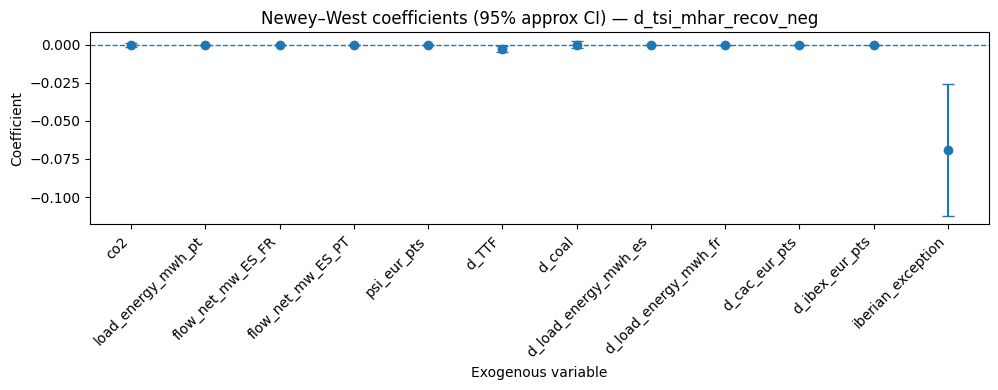

,endog,variable,coef,std_err,t,pval,ci_low,ci_high
12,d_tsi_mhar_recov_neg,iberian_exception,-6.911918e-02,2.204224e-02,-3.135760,0.001714,-1.123212e-01,-2.591718e-02
4,d_tsi_mhar_recov_neg,flow_net_mw_ES_PT,-2.477352e-05,9.203535e-06,-2.691739,0.007108,-4.281211e-05,-6.734920e-06
6,d_tsi_mhar_recov_neg,d_TTF,-2.729753e-03,1.109545e-03,-2.460246,0.013884,-4.904421e-03,-5.550851e-04
2,d_tsi_mhar_recov_neg,load_energy_mwh_pt,-1.046102e-06,5.304360e-07,-1.972154,0.048592,-2.085737e-06,-6.466245e-09
3,d_tsi_mhar_recov_neg,flow_net_mw_ES_FR,-9.442336e-06,4.915861e-06,-1.920790,0.054758,-1.907725e-05,1.925741e-07
5,d_tsi_mhar_recov_neg,psi_eur_pts,-4.326320e-05,2.732673e-05,-1.583182,0.113380,-9.682260e-05,1.029621e-05
8,d_tsi_mhar_recov_neg,d_load_energy_mwh_es,3.390892e-08,2.862722e-08,1.184499,0.236216,-2.219940e-08,9.001723e-08
9,d_tsi_mhar_recov_neg,d_load_energy_mwh_fr,-2.281508e-08,2.848190e-08,-0.801038,0.423110,-7.863858e-08,3.300841e-08
10,d_tsi_mhar_recov_neg,d_cac_eur_pts,-9.408146e-05,1.265001e-04,-0.743726,0.457042,-3.420171e-04,1.538542e-04
1,d_tsi_mhar_recov_neg,co2,-1.995006e-04,7.811894e-04,-0.255381,0.798429,-1.730604e-03,1.331602e-03


In [12]:
# Plot coefficients for ONE endogenous series (default style + basic error bars)

endog_to_plot = endog_names[0]  # pick the first one; change to whichever you want

sub = coef_df[(coef_df["endog"] == endog_to_plot) & (coef_df["variable"] != "const")].copy()

z = 1.96  # approx 95% CI
plt.figure(figsize=(10, 4))
plt.errorbar(
    x=sub["variable"],
    y=sub["coef"],
    yerr=z * sub["std_err"],
    fmt="o",
    capsize=4,
)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xticks(rotation=45, ha="right")
plt.title(f"Newey–West coefficients (95% approx CI) — {endog_to_plot}")
plt.xlabel("Exogenous variable")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()

display(sub.sort_values("pval").head(10))
